In [1]:
# This notebook gathers and cleans company data and then compares the companies using linear regression analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yahoo_fin.stock_info as si
import time

In [2]:
# Load data (ticker symbols and 5 yr projected growth) and check for missing values

link = "https://drive.google.com/uc?export=download&id=1idn5eWrUhTyJqMCUXsKDxQr3wnOpeMRO"
df_excel = pd.read_excel(link, sheet_name='Data')
df_excel

,Ticker,Proj_Growth
0,AAPL,0.0986
1,MSFT,0.145
2,UNH,0.1338
3,JNJ,0.0596
4,V,0.1526
5,WMT,0.0518
6,JPM,0.0536
7,CVX,0.096
8,PG,0.0837
9,HD,0.0832


In [3]:
# Remove rows with missing values

df_new = df_excel.drop(index=28)    # the index value should be changed to drop any tickers without data
df_new = df_new.reset_index(drop=True)
df_new

,Ticker,Proj_Growth
0,AAPL,0.0986
1,MSFT,0.145
2,UNH,0.1338
3,JNJ,0.0596
4,V,0.1526
5,WMT,0.0518
6,JPM,0.0536
7,CVX,0.096
8,PG,0.0837
9,HD,0.0832


In [4]:
# Create list of tickers from the excel data

tickers = df_new['Ticker'].values.tolist()
print(tickers)

['AAPL', 'MSFT', 'UNH', 'JNJ', 'V', 'WMT', 'JPM', 'CVX', 'PG', 'HD', 'KO', 'MRK', 'MCD', 'DIS', 'CSCO', 'VZ', 'CRM', 'NKE', 'AMGN', 'HON', 'IBM', 'AXP', 'GS', 'INTC', 'CAT', 'BA', 'MMM', 'TRV', 'WBA']


In [5]:
PE_list = []
PBV_list = []
ROE_list = []
troublemakers = []

In [6]:
# Gather the data for the analysis

tic = time.perf_counter()

for ticker in tickers:
    try:
        # Get necessary dataframes from the API
        df_temp_1 = si.get_quote_table(ticker)
        df_temp_2 = si.get_stats_valuation(ticker)
        df_temp_2 = df_temp_2.iloc[:,:2]
        df_temp_2.columns = ['Attribute', 'Value']
        df_temp_3 = si.get_stats(ticker)
        
        # Collect relevant data into variables
        PE = df_temp_1['PE Ratio (TTM)']
        PBV = float(df_temp_2.loc[df_temp_2['Attribute']=='Price/Book (mrq)']['Value'].values)
        ROE = str(df_temp_3.loc[df_temp_3['Attribute']=='Return on Equity (ttm)']['Value'].values)
        ROE = float(ROE[2:-3])      # Extra step removes '%' symbol and extra quotes from the text string
        
        # Save the variables in lists
        PE_list.append(PE)
        PBV_list.append(PBV)
        ROE_list.append(ROE)
        
        time.sleep(1)
        
    # Trap errors when data is inaccessable for a ticker
    except Exception as e:
        PE_list.append("N/A")
        PBV_list.append("N/A")
        ROE_list.append("N/A")
        troublemakers.append(ticker)     
        print(ticker, e)
        continue
        
# Time the loop
tok = time.perf_counter()
loop_time = tok - tic
minutes = round((loop_time/60),2)
print("\nThe loop took " + str(minutes) + " minutes to complete.")
print(38 * '=')

# Check the length of the lists to confirm they are complete
print("There are " + str(len(PE_list)) + " values for PE.")
print("There are " + str(len(PBV_list)) + " values for PBV.")
print("There are " + str(len(ROE_list)) + " values for ROE.")

# Print a list of tickers that threw errors
if len(troublemakers) > 0:
    print("\nHere are the troublemakers: " + ' '.join(troublemakers))

HD could not convert string to float: '1,465.50'
MCD could not convert string to float: ''
BA could not convert string to float: ''

The loop took 2.75 minutes to complete.
There are 29 values for PE.
There are 29 values for PBV.
There are 29 values for ROE.

Here are the troublemakers: HD MCD BA


In [7]:
# Take the three separate lists and merge them with the original dataframe

results_df = pd.DataFrame({'PE':PE_list,'PBV':PBV_list,'ROE':ROE_list})
combined_df = pd.concat([df_new, results_df], axis=1)

combined_df

,Ticker,Proj_Growth,PE,PBV,ROE
0,AAPL,0.0986,25.11,47.5,175.46
1,MSFT,0.145,26.38,10.36,42.88
2,UNH,0.1338,25.62,6.63,25.29
3,JNJ,0.0596,24.63,6.18,26.45
4,V,0.1526,30.05,12.48,40.88
5,WMT,0.0518,46.67,5.64,10.65
6,JPM,0.0536,11.4,1.52,12.83
7,CVX,0.096,10.58,2.21,23.16
8,PG,0.0837,25.24,7.81,32.24
9,HD,0.0832,N/A,N/A,N/A


In [8]:
# Clean the data for analysis

# Convert Proj_Growth values for consistency
combined_df['Proj_Growth'] = combined_df['Proj_Growth'] * 100

# Drop tickers with missing data
ticker_pos = combined_df['Ticker'].tolist()
troublemaker_pos = []
for bandido in troublemakers:
    idx = ticker_pos.index(bandido)
    troublemaker_pos.append(idx)    
    
clean_df = combined_df.drop(labels = troublemaker_pos, axis=0)
clean_df = clean_df.reset_index(drop=True)

# Finish data cleaning by changing datatypes to float
float_cols = {'Proj_Growth':float, 'PE':float, 'PBV':float, 'ROE':float}
clean_df = clean_df.astype(float_cols)
clean_df

,Ticker,Proj_Growth,PE,PBV,ROE
0,AAPL,9.86,25.11,47.50,175.46
1,MSFT,14.50,26.38,10.36,42.88
2,UNH,13.38,25.62,6.63,25.29
3,JNJ,5.96,24.63,6.18,26.45
4,V,15.26,30.05,12.48,40.88
5,WMT,5.18,46.67,5.64,10.65
6,JPM,5.36,11.40,1.52,12.83
7,CVX,9.60,10.58,2.21,23.16
8,PG,8.37,25.24,7.81,32.24
9,KO,4.68,27.35,11.77,41.03


In [9]:
# Perform OLS regression analysis on PE vs. Projected Growth to check for statistical significance
x1 = clean_df['Proj_Growth']
y1 = clean_df['PE']

# Add constant
x1 = sm.add_constant(x1)

# Fit the linear regression model
model_1 = sm.OLS(y1, x1).fit()

# View the summary
print(model_1.summary())

# Use the model to generate predictions for further analysis
predict_PE = model_1.predict()
print('\nHere are the predicted values for PE based on the model:')
print(predict_PE)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5.349
Date:                Tue, 22 Nov 2022   Prob (F-statistic):             0.0296
Time:                        15:08:49   Log-Likelihood:                -137.53
No. Observations:                  26   AIC:                             279.1
Df Residuals:                      24   BIC:                             281.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0235     17.635     -0.058      

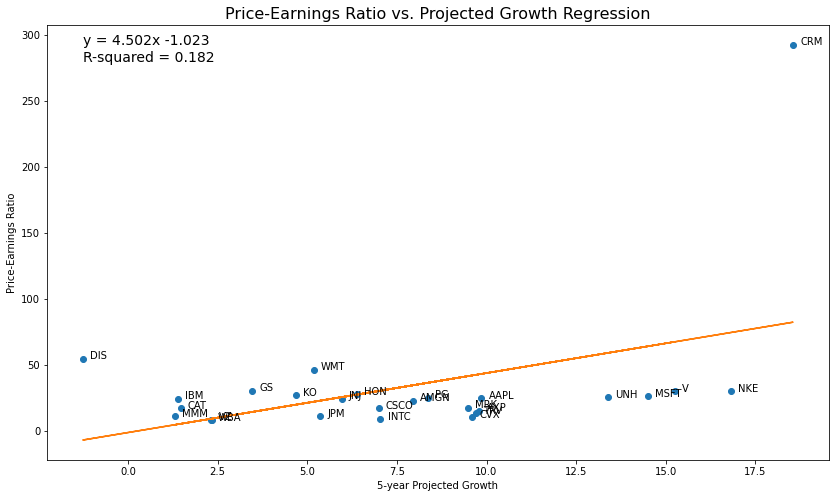

In [10]:
# Visualize PE over Projected Growth Regression

# Prep the variables
x1 = clean_df['Proj_Growth']
y1 = clean_df['PE']
text_coord_x1 = clean_df['Proj_Growth'].min()
text_coord_y1 = clean_df['PE'].max()
labels = clean_df['Ticker']
tick_offset = 0.2

# Create the scatterplot
plt.figure(figsize=(14,8))
plt.plot(x1, y1, 'o')

# Add the regression line to the plot
m1, b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1 * x1 + b1)

# Add labels to the plot
plt.title('Price-Earnings Ratio vs. Projected Growth Regression', size=16)
plt.xlabel('5-year Projected Growth')
plt.ylabel('Price-Earnings Ratio')
plt.text(text_coord_x1, text_coord_y1, 'y = ' + '{:.3f}'.format(m1) + 'x' + ' {:.3f}'.format(b1), size=14)
plt.text(text_coord_x1, text_coord_y1 - 13, 'R-squared = ' + '{:.3f}'.format(model_1.rsquared), size=14)

# Add ticker symbols to the data points
for i, label in enumerate(labels):
    plt.annotate(label, (x1.iloc[i], y1.iloc[i]), xytext=(x1.iloc[i]+tick_offset, y1.iloc[i]-tick_offset))
    

In [11]:
# Quantify how much each ticker is over/undervalued according to the model's predictions

# Sort the list
results = clean_df.loc[:, ('Ticker', 'Proj_Growth', 'PE')]
results['Predicted_PE'] = predict_PE
results['Pct_Over/Undervalued'] = (results['Predicted_PE'] - results['PE']) / results['Predicted_PE'] * 100
results = results.round(2)
PE_reg_results = results.sort_values(by = 'Pct_Over/Undervalued', ascending=False)

# Trap false positives that the sorting function missed
false_positives = []
false_positives_symbols = []
dex = PE_reg_results.index.tolist()
for x in dex:
    if PE_reg_results['Predicted_PE'][x] < 0:
        false_positives.append(x)
        false_positives_symbols.append(PE_reg_results['Ticker'][x])
PE_reg_results = PE_reg_results.drop(false_positives, axis=0)
PE_reg_results.reset_index(inplace=True, drop=True)

# Display the results
print('Stocks at the top of this list are the most undervalued based on this screen: \n')
print(PE_reg_results)
if len(false_positives) > 0:
    print('\nHere are the false positives that were dropped: ' + ' '.join(false_positives_symbols))


Stocks at the top of this list are the most undervalued based on this screen: 

   Ticker  Proj_Growth      PE  Predicted_PE  Pct_Over/Undervalued
0     CVX         9.60   10.58         42.19                 74.93
1    INTC         7.04    9.23         30.67                 69.90
2     TRV         9.70   13.69         42.64                 67.90
3     AXP         9.80   15.50         43.09                 64.03
4     NKE        16.82   30.10         74.70                 59.70
5    MSFT        14.50   26.38         64.25                 58.94
6     MRK         9.47   17.73         41.61                 57.39
7     UNH        13.38   25.62         59.21                 56.73
8       V        15.26   30.05         67.67                 55.60
9     JPM         5.36   11.40         23.11                 50.66
10   CSCO         6.99   17.47         30.44                 42.62
11   AAPL         9.86   25.11         43.36                 42.10
12   AMGN         7.94   23.04         34.72     

In [12]:
# Perform OLS regression analysis on PBV vs. ROE to check for statistical significance
x2 = clean_df['ROE']
y2 = clean_df['PBV']

# Add constant
x2 = sm.add_constant(x2)

# Fit the linear regression model
model_2 = sm.OLS(y2, x2).fit()

# View the summary
print(model_2.summary())

# Use the model to generate predictions for further analysis
predict_PBV = model_2.predict()
print('\nHere are the predicted values for PBV based on the model:')
print(predict_PBV)

                            OLS Regression Results                            
Dep. Variable:                    PBV   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     225.4
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           1.06e-13
Time:                        15:09:38   Log-Likelihood:                -68.872
No. Observations:                  26   AIC:                             141.7
Df Residuals:                      24   BIC:                             144.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6524      0.970     -1.704      0.1

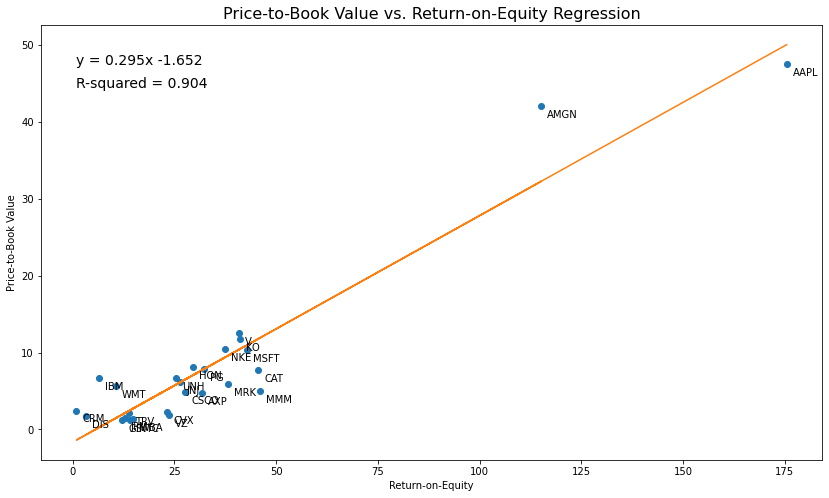

In [13]:
# Visualize PBV over ROE Regression

# Prep the variables
x2 = clean_df['ROE']
y2 = clean_df['PBV']
text_coord_x2 = clean_df['ROE'].min()
text_coord_y2 = clean_df['PBV'].max()
tick_offset = 1.5

# Create the scatterplot
plt.figure(figsize=(14,8))
plt.plot(x2, y2, 'o')

# Add the regression line to the plot
m2, b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2 * x2 + b2)

# Add labels to the plot
plt.title('Price-to-Book Value vs. Return-on-Equity Regression', size=16)
plt.xlabel('Return-on-Equity')
plt.ylabel('Price-to-Book Value')
plt.text(text_coord_x2, text_coord_y2, 'y = ' + '{:.3f}'.format(m2) + 'x' + ' {:.3f}'.format(b2), size=14)
plt.text(text_coord_x2, text_coord_y2 - 3, 'R-squared = ' + '{:.3f}'.format(model_2.rsquared), size=14)

# Add ticker symbols to the data points
for i, label in enumerate(labels):
    plt.annotate(label, (x2.iloc[i], y2.iloc[i]), xytext=(x2.iloc[i]+tick_offset, y2.iloc[i]-tick_offset))


In [14]:
# Quantify how much each ticker is over/undervalued based on the model's predictions

# Sort the list
results = clean_df.loc[:, ('Ticker', 'ROE', 'PBV')]
results['Predicted_PBV'] = predict_PBV
results['Pct_Over/Undervalued'] = (results['Predicted_PBV'] - results['PBV']) / results['Predicted_PBV'] * 100
results = results.round(2)
PBV_reg_results = results.sort_values(by = 'Pct_Over/Undervalued', ascending=False)

# Trap false positives that the sorting function missed
false_positives_2 = []
false_positives_symbols_2 = []
dex = PBV_reg_results.index.tolist()
for x in dex:
    if PBV_reg_results['Predicted_PBV'][x] < 0:
        false_positives_2.append(x)
        false_positives_symbols_2.append(PBV_reg_results['Ticker'][x])
PBV_reg_results = PBV_reg_results.drop(false_positives_2, axis=0)
PBV_reg_results.reset_index(inplace=True, drop=True)

# Display the results
print('Stocks at the top of this list are the most undervalued based on this screen: \n')
print(PBV_reg_results)
if len(false_positives_2) > 0:
    print('\nHere are the false positives that were dropped: ' + ' '.join(false_positives_symbols_2))


Stocks at the top of this list are the most undervalued based on this screen: 

   Ticker     ROE    PBV  Predicted_PBV  Pct_Over/Undervalued
0      VZ   23.66   1.85           5.32                 65.22
1     MMM   45.93   5.01          11.88                 57.83
2     CVX   23.16   2.21           5.17                 57.26
3     WBA   14.90   1.36           2.74                 50.32
4    INTC   14.00   1.23           2.47                 50.25
5      GS   12.17   1.18           1.93                 38.96
6     AXP   31.68   4.76           7.68                 38.03
7     MRK   38.14   5.94           9.58                 38.03
8     CAT   45.61   7.72          11.79                 34.50
9     JPM   12.83   1.52           2.13                 28.56
10   CSCO   27.72   4.87           6.51                 25.25
11    TRV   13.87   2.17           2.43                 10.85
12   MSFT   42.88  10.36          10.98                  5.66
13   AAPL  175.46  47.50          50.04             